# Подготовка модели распознавания рукописных букв и цифр

Вам предстоит самостоятельно обучить модель для задачи распознавания рукописных букв и цифр с помощью датасета `emnist`. Результатом должна быть обученная модель, сохранённая в файл `model.pkl`.

Можете воспользоваться предложенным порядком действий и подсказками из этого ноутбука или подойти к решению задачи самостоятельно и написать всё с нуля. То же касается и процесса упаковки модели в сервис для распознавания самостоятельно написанных символов.

В этом ноутбуке комментариями и символами `...` отмечены места для вашего кода.

Перед отправкой решения убедитесь, что все ячейки ноутбука выполняются последовательно без ошибок, если запустить `Kernel -> Restart & Run All`.

Успехов!

### 1. Установите и импортируйте необходимые библиотеки

In [1]:
# !pip install emnist

In [38]:
import os
import pickle
import emnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

### 2. Загрузите датасет и проанализируйте его

Датасет в качестве лейблов (или таргетов) содержит числа от 0 до 46. Каждому числу соответствует ASCII-код некоторого символа. Пары «лейбл — код» хранятся в файле `emnist-balanced-mapping.txt`.
Выведите на экран количество семплов в каждом сплите датасета и размер изображений. Также для каждого лейбла выведите соответствующий ему символ и количество тренировочных семплов, приходящееся на него.
Посмотрите на несколько примеров изображений.

_Подсказка: чтобы получить символ из ASCII-кода, нужно воспользоваться функцией_ `chr()`. _Для вашего удобства можно построить словарь_ (`dict`) _соответствий._

In [4]:
images_train, labels_train = emnist.extract_training_samples('balanced')
images_test, labels_test = emnist.extract_test_samples('balanced')
print(f'Train size: {images_train.shape[0]} samples')
print(f'Test size: {images_test.shape[0]} samples')
print(f'Image size: {images_train[0].shape}')

Train size: 112800 samples
Test size: 18800 samples
Image size: (28, 28)


In [5]:
# словарь для раскодирования символов
char_map = {}

with open('emnist-balanced-mapping.txt') as file:
    for line in file:
        idx, char = map(int, line.strip().split())
        char_map[idx] = chr(char)

In [6]:
print("Character | Train samples | Test samples")

for idx_tr, count_tr, idx_te, count_te in zip(*np.unique(labels_train, return_counts=True), *np.unique(labels_test, return_counts=True)):
    if idx_tr != idx_te:
        count_te = '?'
    print(f"{repr(char_map[idx_tr]) :^9} | {count_tr :^13} | {count_te :^12}")

Character | Train samples | Test samples
   '0'    |     2400      |     400     
   '1'    |     2400      |     400     
   '2'    |     2400      |     400     
   '3'    |     2400      |     400     
   '4'    |     2400      |     400     
   '5'    |     2400      |     400     
   '6'    |     2400      |     400     
   '7'    |     2400      |     400     
   '8'    |     2400      |     400     
   '9'    |     2400      |     400     
   'A'    |     2400      |     400     
   'B'    |     2400      |     400     
   'C'    |     2400      |     400     
   'D'    |     2400      |     400     
   'E'    |     2400      |     400     
   'F'    |     2400      |     400     
   'G'    |     2400      |     400     
   'H'    |     2400      |     400     
   'I'    |     2400      |     400     
   'J'    |     2400      |     400     
   'K'    |     2400      |     400     
   'L'    |     2400      |     400     
   'M'    |     2400      |     400     
   'N'    |     

#### 2.1 Визуализация сэмпла

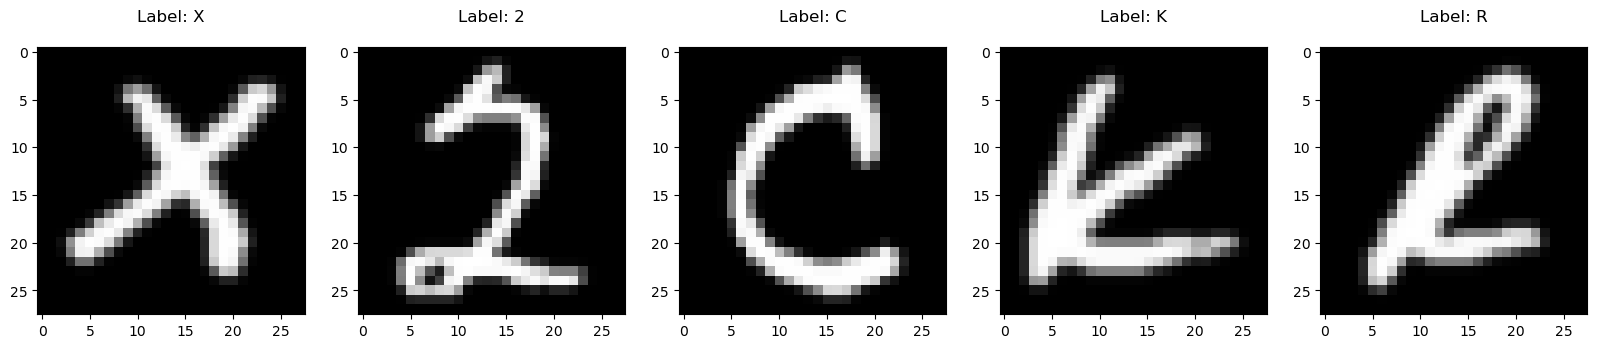

In [7]:
samp = np.random.randint(0, images_train.shape[0], 5)

fig, axs = plt.subplots(1, 5, figsize=(20,4))
for i, idx in enumerate(samp):
    axs[i].imshow(images_train[idx], cmap='gray')
    axs[i].set_title(f'Label: {char_map[labels_train[idx]]}\n')

### 3. Подготовьте датасет для обучения и валидации

_Подсказка: чтобы вытянуть изображения в вектор, понадобится метод_ `reshape` _из библиотеки_ `numpy`.

In [8]:
X_train = np.vstack([image.reshape((28*28,)) for image in images_train])
y_train = labels_train
X_test = np.vstack([image.reshape((28*28,)) for image in images_test])
y_test = labels_test

print('Train:', X_train.shape)
print('Test:', X_test.shape)

Train: (112800, 784)
Test: (18800, 784)


### 4. Выберите модель, обучите её, протестируйте и сохраните

Выведите на экран точность вашей модели. Выведите и проанализируйте матрицу ошибок. Какие два символа она чаще всего путает? На каком символе модель чаще всего ошибается?

#### 4.1 Logistic Regression

In [10]:
logr = LogisticRegression(
    max_iter=5000,
    random_state=44
)
logr.fit(X_train, y_train)

C:\Users\Arseniy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=5000, random_state=44)

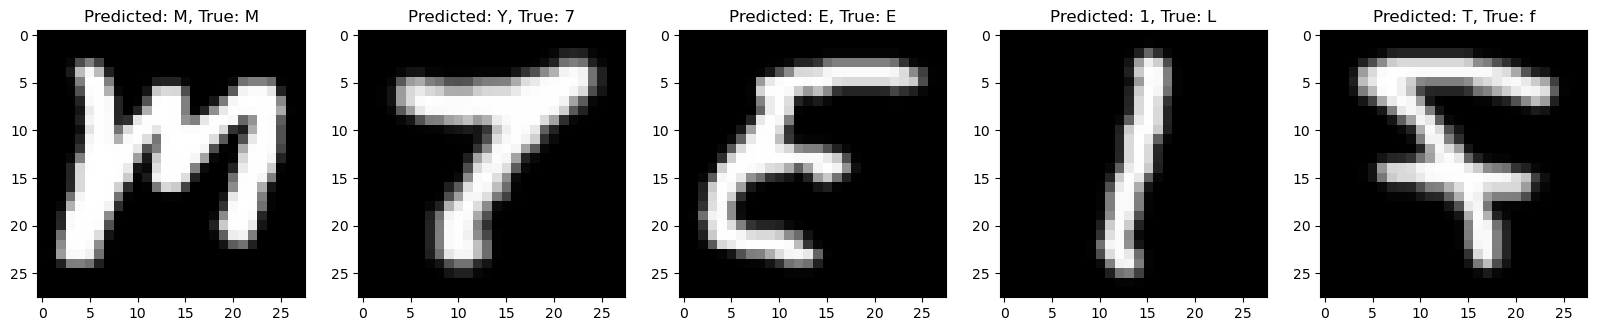

In [11]:
test_idx = np.random.choice(X_test.shape[0], 5)
y_pred = logr.predict(X_test[test_idx])

fig, axs = plt.subplots(1, 5, figsize=(20,12))
for i, idx in enumerate(test_idx):
    axs[i].imshow(X_test[idx].reshape(28, 28), cmap='gray')
    axs[i].set_title(f'Predicted: {char_map[y_pred[i]]}, True: {char_map[labels_test[idx]]}')

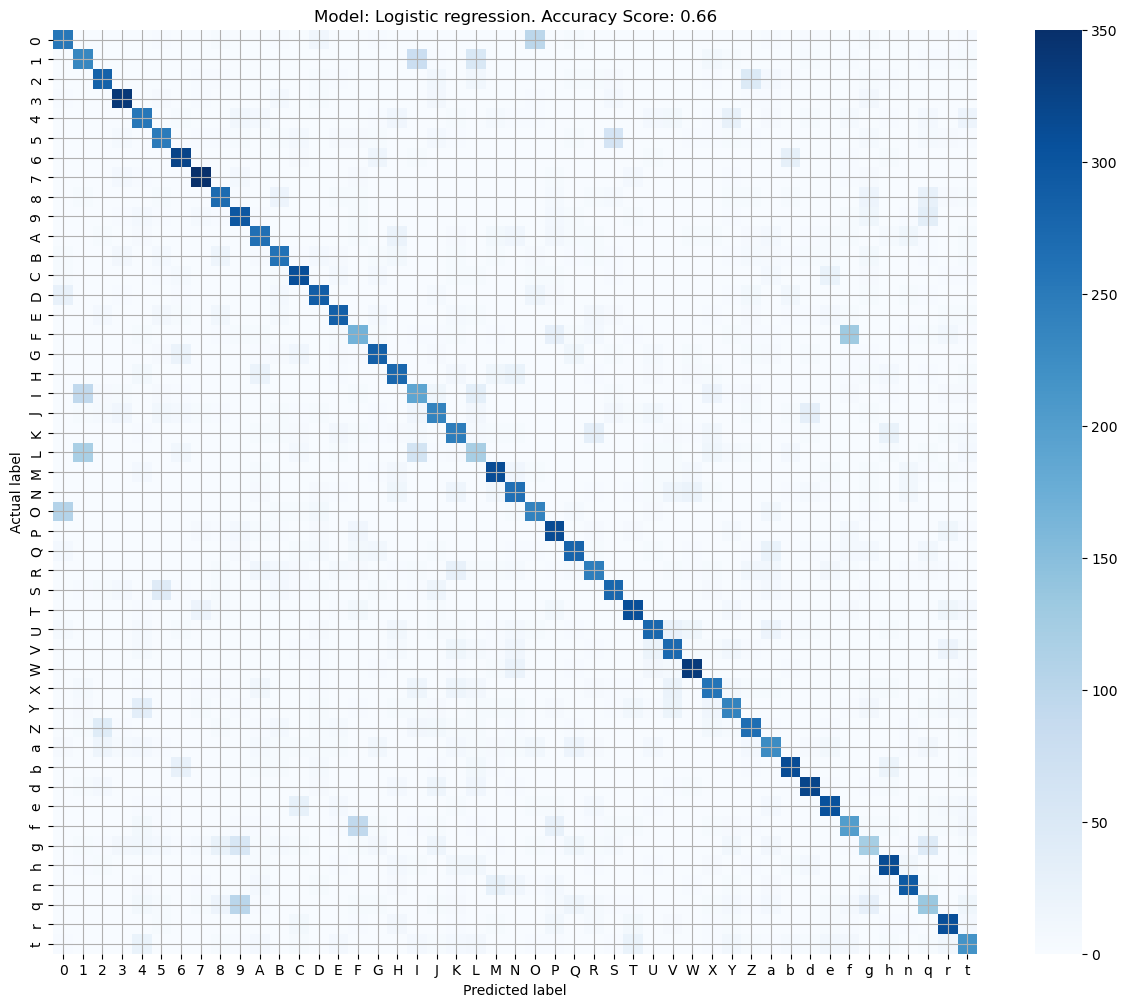

In [12]:
y_pred = logr.predict(X_test)

ticks = [char_map[x] for x in np.unique(y_test)]

acc = accuracy_score(y_test, y_pred)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), ticks, ticks)

plt.figure(figsize=(15, 12))

sns.heatmap(cm, square=True, cmap='Blues')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Model: Logistic regression. Accuracy Score: {acc:.2f}')
plt.grid()
plt.show();

In [13]:
print('Модель логистической регрессии чаще всего ошибается в определении символа:')
char_map[cm.values.diagonal().argmin()]

Модель логистической регрессии чаще всего ошибается в определении символа:


'L'

In [14]:
np.fill_diagonal(cm.values, 0)
idx = np.unravel_index(np.argmax(cm.values, axis=None), cm.values.shape)

print('Самая частая ошибка:')
print(f"{cm.index[idx[0]]} определяется как {cm.index[idx[1]]}")

Самая частая ошибка:
F определяется как f


#### 4.2 Random Forest

In [15]:
forest = RandomForestClassifier(
    random_state=44
)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=44)

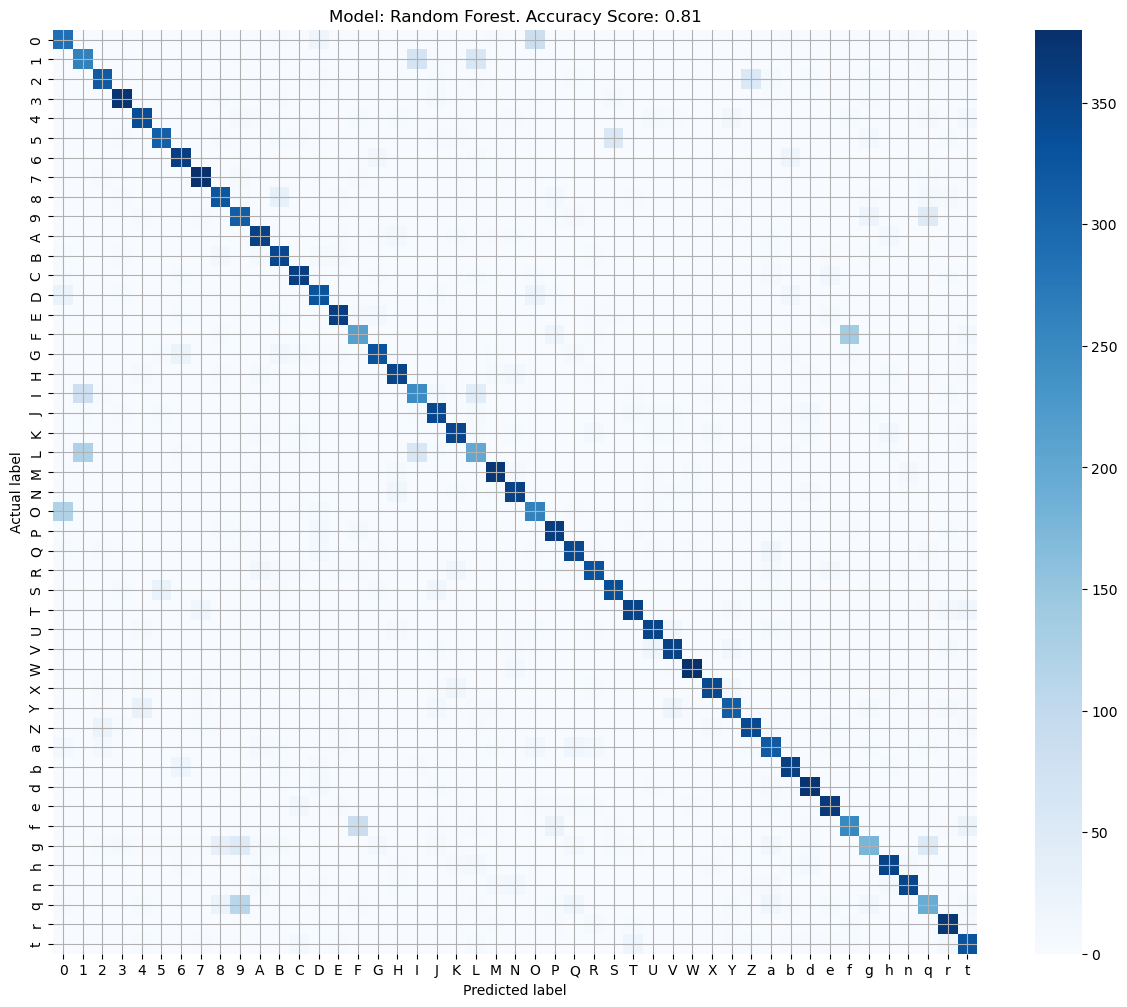

In [16]:
y_pred = forest.predict(X_test)

ticks = [char_map[x] for x in np.unique(y_test)]

acc = accuracy_score(y_test, y_pred)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), ticks, ticks)

plt.figure(figsize=(15, 12))

sns.heatmap(cm, square=True, cmap='Blues')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Model: Random Forest. Accuracy Score: {acc:.2f}')
plt.grid()
plt.show();

In [17]:
print('Модель Random Forest чаще всего ошибается в определении символа:')
char_map[cm.values.diagonal().argmin()]

Модель Random Forest чаще всего ошибается в определении символа:


'g'

In [18]:
np.fill_diagonal(cm.values, 0)
idx = np.unravel_index(np.argmax(cm.values, axis=None), cm.values.shape)

print('Самая частая ошибка:')
print(f"{cm.index[idx[0]]} определяется как {cm.index[idx[1]]}")

Самая частая ошибка:
F определяется как f


#### 4.3 Hist Gradient Boosting

In [19]:
hgb = HistGradientBoostingClassifier(
    random_state=44,
)
hgb.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=44)

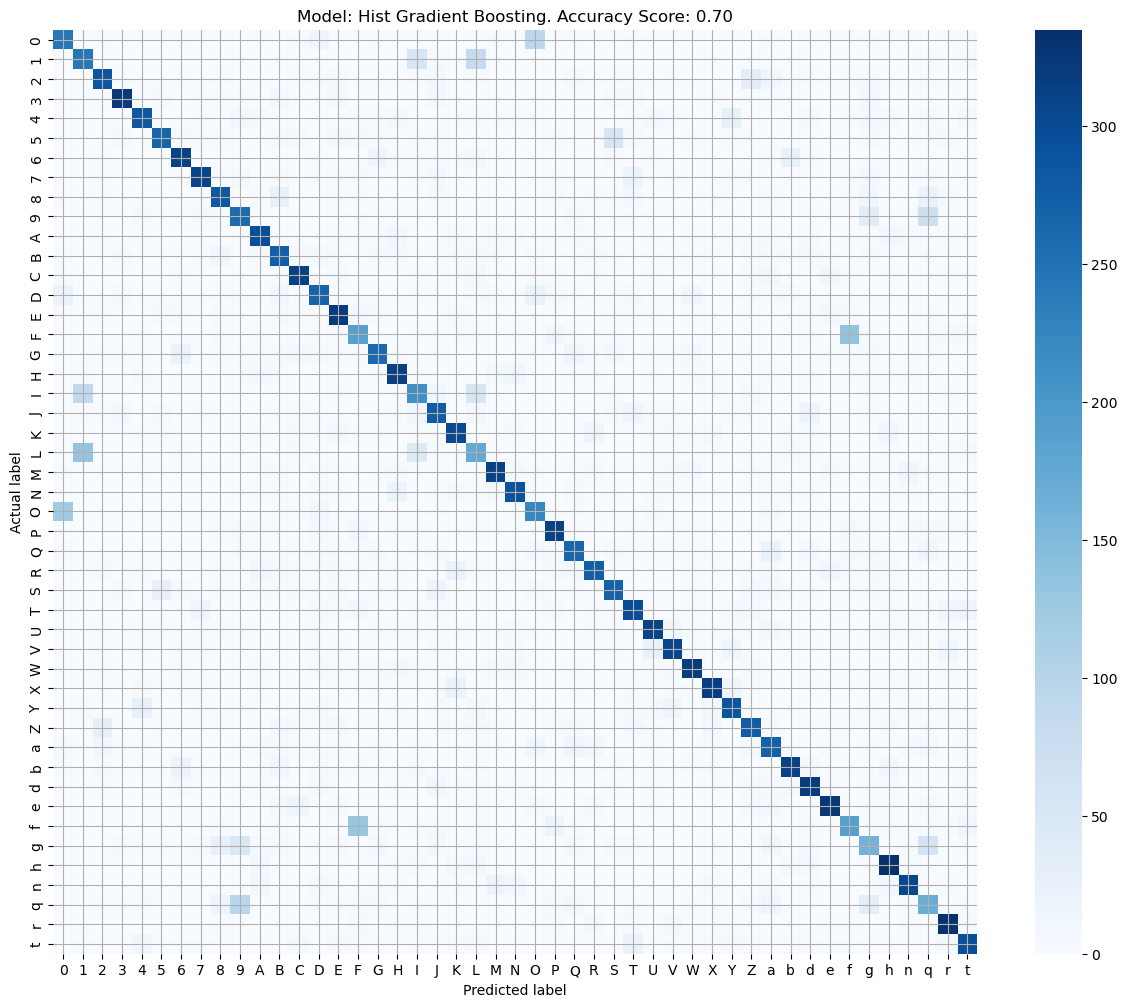

In [20]:
y_pred = hgb.predict(X_test)

ticks = [char_map[x] for x in np.unique(y_test)]

acc = accuracy_score(y_test, y_pred)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), ticks, ticks)

plt.figure(figsize=(15, 12))

sns.heatmap(cm, square=True, cmap='Blues')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Model: Hist Gradient Boosting. Accuracy Score: {acc:.2f}')
plt.grid()
plt.show();

In [21]:
print('Модель бустинга чаще всего ошибается в определении символа:')
char_map[cm.values.diagonal().argmin()]

Модель бустинга чаще всего ошибается в определении символа:


'g'

In [22]:
np.fill_diagonal(cm.values, 0)
idx = np.unravel_index(np.argmax(cm.values, axis=None), cm.values.shape)

print('Самая частая ошибка:')
print(f"{cm.index[idx[0]]} определяется как {cm.index[idx[1]]}")

Самая частая ошибка:
F определяется как f


#### 4.4 MLP

In [23]:
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128, ),
    random_state=44
)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(512, 256, 128), random_state=44)

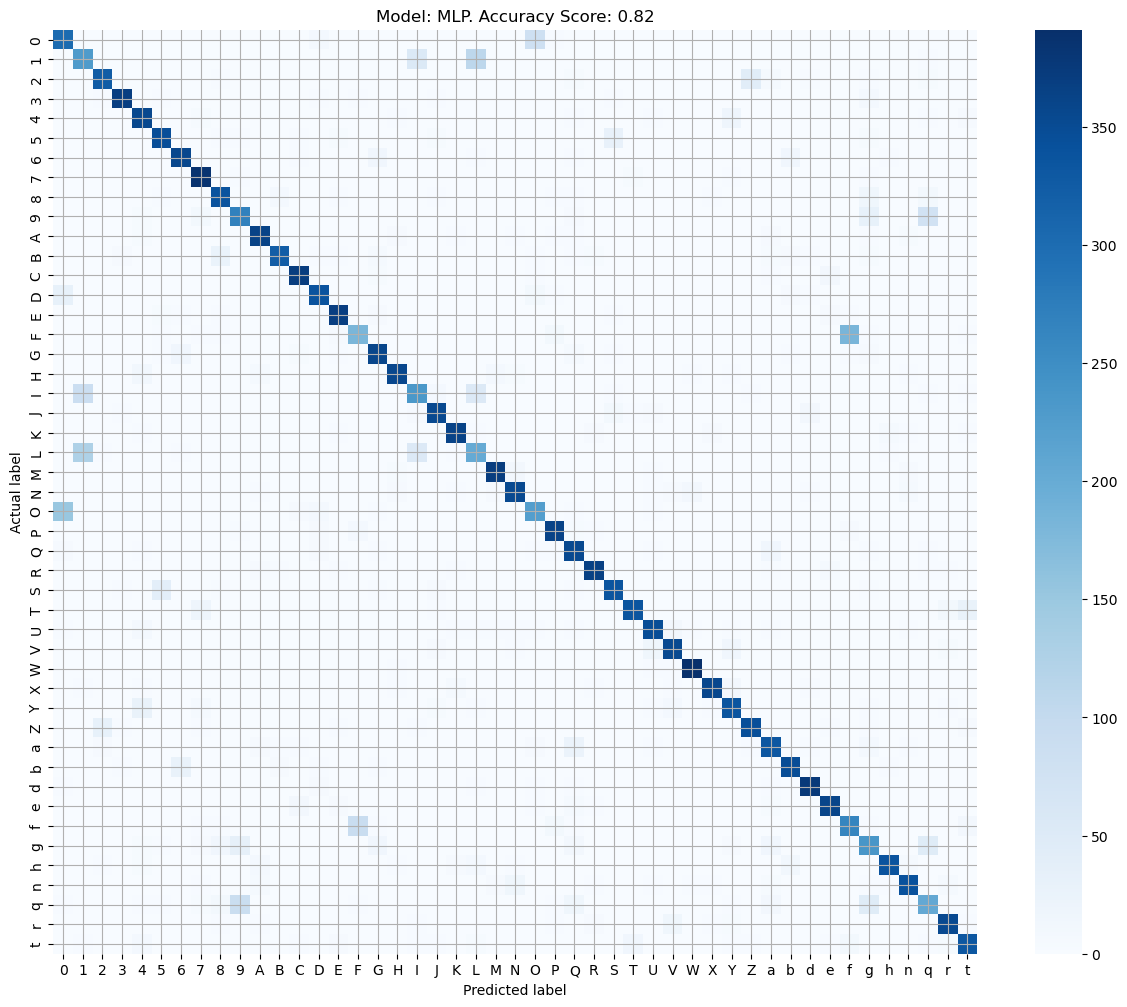

In [24]:
y_pred = mlp.predict(X_test)

ticks = [char_map[x] for x in np.unique(y_test)]

acc = accuracy_score(y_test, y_pred)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), ticks, ticks)

plt.figure(figsize=(15, 12))

sns.heatmap(cm, square=True, cmap='Blues')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Model: MLP. Accuracy Score: {acc:.2f}')
plt.grid()
plt.show();

In [25]:
print('Модель MLP чаще всего ошибается в определении символа:')
char_map[cm.values.diagonal().argmin()]

Модель MLP чаще всего ошибается в определении символа:


'F'

In [26]:
np.fill_diagonal(cm.values, 0)
idx = np.unravel_index(np.argmax(cm.values, axis=None), cm.values.shape)

print('Самая частая ошибка:')
print(f"{cm.index[idx[0]]} определяется как {cm.index[idx[1]]}")

Самая частая ошибка:
F определяется как f


### Итог

Самой точной оказалась модель MLP\
Accuracy: 0.82

In [43]:
model = mlp

In [47]:
result = {
    'model': model,
    'type': model.__class__.__name__,
    'accuracy': acc,
    'char map dict': char_map,
    'timestamp': datetime.now().isoformat(),
    'info': 'The classification model for written character detection based on a 28x28 image in Numpy format',
    'author': 'Arseniy Kubanov',
}

In [49]:
with open(os.path.join('myapp', 'model.pkl'),'wb') as f:
    pickle.dump(result, f)